## Module

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

from sklearn import metrics

## Preprocessing

In [93]:
#Loading the Dataframe
Dataset_std = pd.read_pickle("Data_te_std.pkl")   #Standardized Dataset
Attack_label = pd.read_pickle("Attack_label.pkl") #Attack Labels 0:Normal, 1:Attack
Attack_type_raw = pd.read_pickle("Attack_type.pkl")   #Attack Types 
mapping_dict = {'DDoS_UDP': 1, 'DDoS_ICMP': 1, 'DDoS_HTTP': 1, 'DDoS_TCP': 1,
                'Port_Scanning': 2, 'Fingerprinting': 2, 'Vulnerability_scanner': 2,
                'MITM' : 3, 'XSS' : 4, 'SQL_injection': 4, 'Uploading':4, 
                'Backdoor': 5, 'Password': 5, 'Ransomware':5, 'Normal':6}
Attack_type = Attack_type_raw.map(mapping_dict)

#Oversampling the minority classes
Dataset, Target_type = SMOTEENN(random_state= 22).fit_resample(Dataset_std, Attack_type)
Target_label = Target_type.apply(lambda x: 0 if x == 6 else 1)

#Splitting the dataset into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(Dataset, Target_type, train_size=5000, test_size=60000, random_state=22) 
_, _, Y_ref, _ = train_test_split(Dataset, Target_type, train_size=5000 ,test_size=60000, random_state=22)

## Functions

In [97]:
#Function to get the indices of the attack type
def get_index(attack_type: int, data: np.ndarray) -> np.ndarray:
    indices = np.where(data[:] == attack_type)[0]
    return indices  
#Function to remove a attack type from the dataframe
def remove_attack_type(data_X: np.ndarray, attack_type: int) -> np.ndarray:
    indices_to_remove = get_index(attack_type, Y_ref)
    new_data = np.delete(data_X, indices_to_remove, axis=0)
    return new_data

#Evaluation Function
def evaluate_clf(model, test: np.ndarray, pred: np.ndarray, display:bool = True) -> None:
    df_metric = pd.DataFrame({'Accuracy': metrics.accuracy_score(test, pred),
                              'Precison': metrics.precision_score(test, pred, average= None),
                              'Recall': metrics.recall_score(test, pred, average= None),
                              'F1-Score': metrics.f1_score(test, pred, average= None)
                            }, index= [1,2,3,4,5,6])
    if display:
        cm = metrics.confusion_matrix(test, pred, labels=model.classes_) #normalize= 'true'
        metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot()
    return df_metric

#Function for looping training and testing
def train_and_eval(model, x, y):
    y_pred = model.fit(x, y).predict(X_test)
    return evaluate_clf(model, Y_test, y_pred, False)

In [82]:
svc = SVC(kernel ='rbf', C= 1e4, decision_function_shape= 'ovo', probability= True)
linsvc = CalibratedClassifierCV(estimator=LinearSVC(), method='sigmoid')
knn = KNeighborsClassifier(n_neighbors= 6, weights= 'distance', algorithm= 'auto', leaf_size= 20, p= 1)
rf = RandomForestClassifier(n_estimators=80, max_samples= 0.8, max_depth=11,
                                max_features= 0.9, criterion= 'gini', random_state=22, oob_score= True)
vote_clf = VotingClassifier(estimators=[('SVC', svc), ('linear SVC', linsvc), ('KNN', knn), ('Random Forest', rf)], voting='soft')

## Voting Multiclassifier

Accuracy  Precison    Recall  F1-Score
Model           Classes                                        
SVC             1        0.916333  0.995250  0.984660  0.989927
                2        0.916333  0.977441  0.966884  0.972134
                3        0.916333  0.998288  1.000000  0.999144
                4        0.916333  0.695912  0.626231  0.659235
                5        0.916333  0.733913  0.948421  0.827492
                6        0.916333  0.993866  0.760775  0.861839
Linear SVC      1        0.845417  0.975380  0.734173  0.837760
                2        0.845417  0.790558  0.976078  0.873577
                3        0.845417  0.988663  0.998766  0.993689
                4        0.845417  0.722998  0.394204  0.510219
                5        0.845417  0.632631  0.961397  0.763110
                6        0.845417  0.995637  0.714303  0.831826
KNN             1        0.902533  0.957496  0.886859  0.920825
                2        0.902533  0.874896  0.942605  0.907489
                3        0.902533  0.998972  1.000000  0.999486
                4        0.902533  0.686360  0.643136  0.664045
                5        0.902533  0.847309  0.939663  0.891099
                6        0.902533  0.903651  0.825427  0.862770
Random Forest   1        0.971617  0.998378  0.982266  0.990257
                2        0.971617  0.993674  0.995448  0.994560
                3        0.971617  0.999863  1.000000  0.999931
                4        0.971617  0.817043  0.920862  0.865852
                5        0.971617  0.989970  0.928525  0.958264
                6        0.971617  0.950335  0.956056  0.953187
Voting Ensemble 1        0.928050  0.998292  0.984483  0.991339
                2        0.928050  0.947620  0.989913  0.968305
                3        0.928050  0.999041  1.000000  0.999520
                4        0.928050  0.770081  0.685677  0.725432
                5        0.928050  0.777255  0.945934  0.853339
                6        0.928050  0.990507  0.778835  0.872009

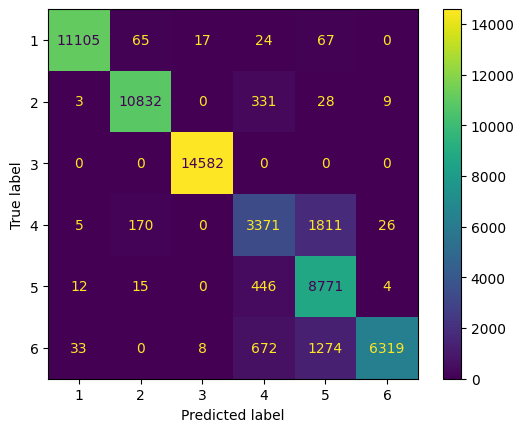

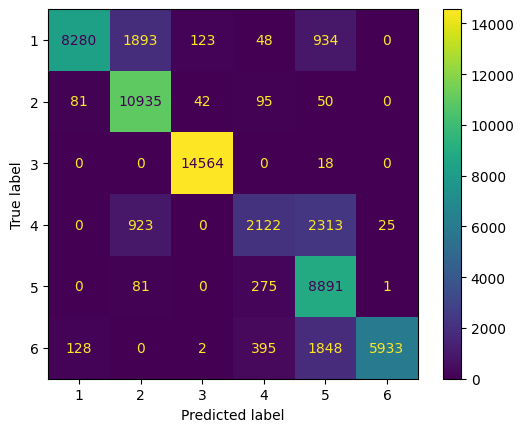

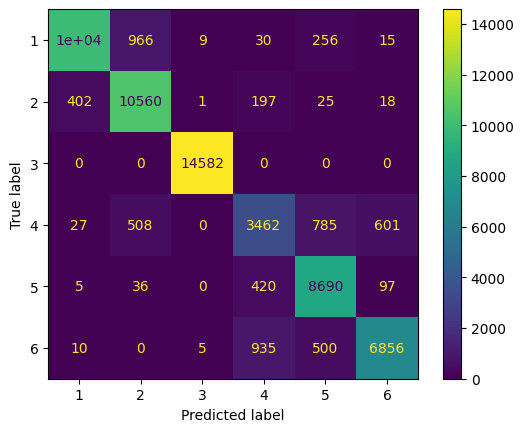

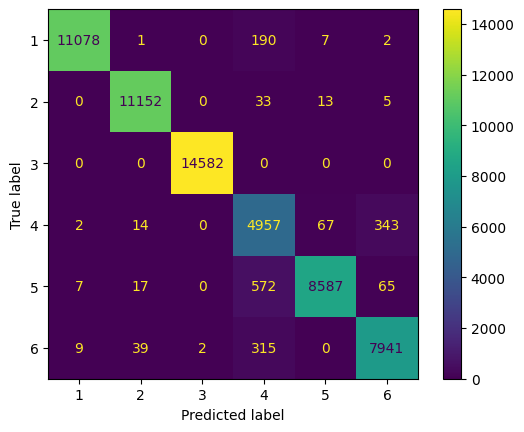

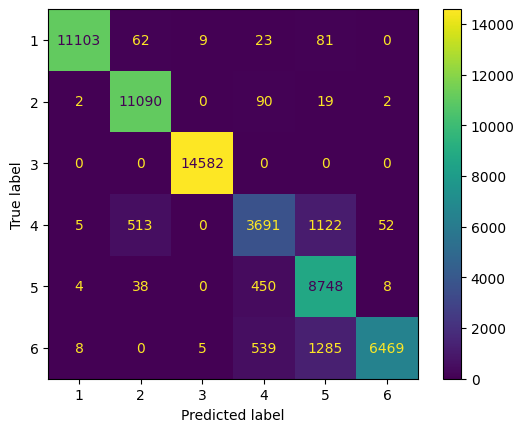

In [96]:
models = {'SVC':svc, 'Linear SVC': linsvc, 'KNN':knn, 'Random Forest':rf, 'Voting Ensemble':vote_clf}

results = pd.DataFrame()
for model_name, model in models.items(): 
    results = pd.concat([results, train_and_eval(model, X_train, Y_train)], axis=0, ignore_index=True)

results.index = pd.MultiIndex.from_product([models.keys(), np.arange(1,7)], names=['Model', 'Classes'])
results

<Axes: title={'center': 'Accuracy of the Models'}, xlabel='Model'>

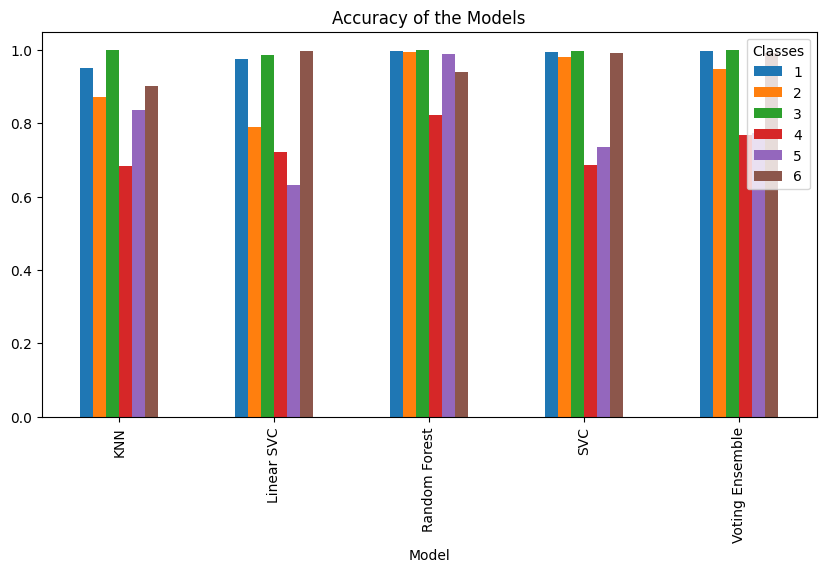

In [94]:
results['Precison'].unstack().plot(kind='bar', figsize=(10,5), title='Accuracy of the Models')

,Accuracy,Precison,Recall,F1-Score
Anamoly_weighted,0.947033,0.950723,0.947033,0.94742


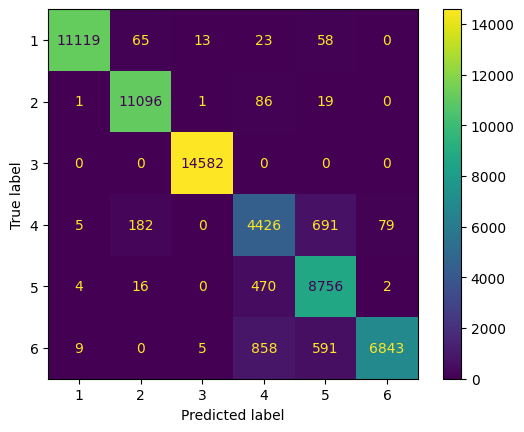

In [17]:
#Voting Classifier
vote_clf.fit(X_train, Y_train)
Y_pred = vote_clf.predict(X_test)
evaluate_clf(vote_clf, Y_test, Y_pred)

## Novel Attacks

In [69]:
#Training set without the novel attack types
X_train_nov1 = remove_attack_type(np.array(X_train), 1)
Y_train_nov1 = remove_attack_type(np.array(Y_train), 1)
X_train_nov2 = remove_attack_type(np.array(X_train), 2)
Y_train_nov2 = remove_attack_type(np.array(Y_train), 2)
X_train_nov3 = remove_attack_type(np.array(X_train), 3)
Y_train_nov3 = remove_attack_type(np.array(Y_train), 3)
X_train_nov4 = remove_attack_type(np.array(X_train), 4)
Y_train_nov4 = remove_attack_type(np.array(Y_train), 4)
X_train_nov5 = remove_attack_type(np.array(X_train), 5)
Y_train_nov5 = remove_attack_type(np.array(Y_train), 5)

trainings = [(X_train_nov1, Y_train_nov1), (X_train_nov2, Y_train_nov2), (X_train_nov3, Y_train_nov3),
             (X_train_nov4, Y_train_nov4), (X_train_nov5, Y_train_nov5)]
models = {'SVC':svc, 'Linear SVC': linsvc, 'KNN':knn, 'Random Forest':rf, 'Voting Ensemble':vote_clf}

model_results = pd.DataFrame()
for model_name, model in models.items(): 
    result = pd.DataFrame()
    for i, (x, y) in enumerate(trainings):
        result = pd.concat([result, train_and_eval(model, x, y)], axis=0, ignore_index=True)
    model_results = pd.concat([model_results, result], axis=0)

model_results.index = pd.MultiIndex.from_product([models.keys(), ['novel type 1', 'novel type 2', 'novel type 3', 'novel type 4', 'novel type 5'],
                                                 np.arange(1,7)], names=['Model', 'Novel Type', 'Classes'])
model_results.head(20)

Accuracy  Precison    Recall  F1-Score
Model           Novel Type   Classes                                        
SVC             novel type 1 1        0.732017  0.000000  0.000000  0.000000
                             2        0.732017  0.668476  0.967419  0.790633
                             3        0.732017  0.739715  1.000000  0.850386
                             4        0.732017  0.658847  0.626045  0.642027
                             5        0.732017  0.699587  0.952855  0.806812
...                                        ...       ...       ...       ...
Voting Ensemble novel type 5 2        0.813283  0.957945  0.990181  0.973796
                             3        0.813283  0.998699  1.000000  0.999349
                             4        0.813283  0.445484  0.955601  0.607679
                             5        0.813283  0.000000  0.000000  0.000000
                             6        0.813283  0.968679  0.819167  0.887671

[150 rows x 4 columns]

<Axes: title={'center': 'F1-Score of Models on Novel Attack Types'}, xlabel='Models'>

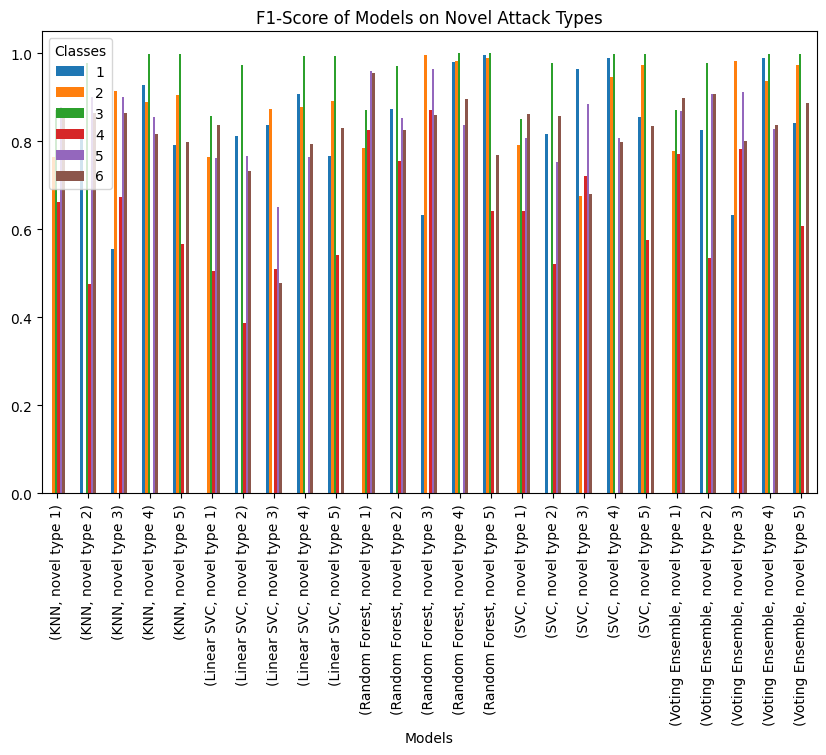

In [72]:
model_results['F1-Score'].unstack().plot(kind='bar', figsize=(10, 6), title='F1-Score of Models on Novel Attack Types', xlabel='Models')

<Axes: title={'center': 'Precision of Models on Novel Attack Types'}, xlabel='Model,Novel Type'>

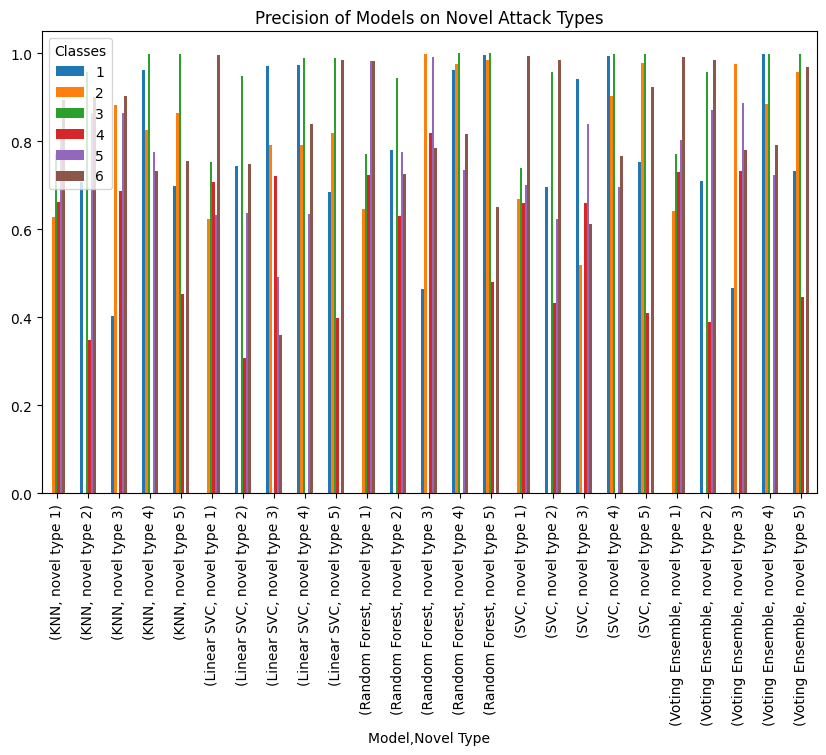

In [74]:
model_results['Precison'].unstack().plot(kind='bar', figsize=(10, 6), title='Precision of Models on Novel Attack Types')